In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

article = pd.read_csv('../data/article_info.csv')

titles = article['Title'].tolist()
t_embeddings = model.encode(titles)

contents = article['Content'].tolist()
c_embeddings = model.encode(contents)

# 유저별로 조회한 기사들의 임베딩을 추출 (예시로 title 임베딩 사용)
user_article_data = pd.read_csv('../data/view_log.csv')  # 유저-기사 조회 기록


/home/elicer/.anaconda3/envs/dacon/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-10-20 08:32:39.504468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 08:32:39.569725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 08:32:39.605052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one ha

In [3]:
np.savetxt('../cached/t_embedding', t_embeddings)
np.savetxt('../cached/c_embedding', c_embeddings)

In [4]:
import sys
sys.path.append('../')
from modules.utils import *
article2idx, idx2article, idx2user, user2idx = load_dict()

In [5]:
user_article_data['articleID'] = user_article_data['articleID'].apply(lambda x:article2idx[x])
user_article_data['userID'] = user_article_data['userID'].apply(lambda x:user2idx[x])

In [ ]:
t_cosine_sim = util.cos_sim(t_embeddings, t_embeddings)
c_cosine_sim = util.cos_sim(c_embeddings, c_embeddings)

In [39]:
def get_user_cosine_sim(embedding):
    # 유저별로 코사인 유사도를 저장할 딕셔너리
    user_cosine_sims = {}
    user_cosine_means = {}

    # 각 유저별 조회한 기사들의 코사인 유사도 계산
    for user_id in user_article_data['userID'].unique():
        # 해당 유저가 조회한 기사 ID 추출
        user_articles = user_article_data[user_article_data['userID'] == user_id]['articleID'].tolist()
        
        # 조회한 기사들의 코사인 유사도 행렬에서 유저가 본 기사에 해당하는 부분 추출
        if len(user_articles) > 1:
            # 기사 ID에 해당하는 코사인 유사도 행렬 부분 추출
            user_sim_matrix = embedding[np.ix_(user_articles, user_articles)]
            
            # 상삼각행렬의 유사도 값만 추출 (자기 자신과의 유사도는 제외)
            triu_indices = np.triu_indices_from(user_sim_matrix, k=1)
            user_sim_values = user_sim_matrix[triu_indices]
            
            # 유사도 값 저장
            user_cosine_sims[user_id] = user_sim_values
            
            # 유사도 평균값 저장
            user_cosine_means[user_id] = np.mean(user_sim_values.cpu().numpy())
        else:
            # 기사 1개 이하일 경우 유사도를 계산할 수 없으므로 NaN 처리
            user_cosine_sims[user_id] = np.nan
            user_cosine_means[user_id] = np.nan

    return user_cosine_sims, user_cosine_means


In [40]:
user_cosine_sims, user_cosine_means = get_user_cosine_sim(c_cosine_sim)

In [61]:
# 예시 코드: 분산과 표준편차 계산

data = list(filter(lambda x:x is not np.nan, user_cosine_means.values()))

mean_cosine_similarity = np.mean(data)
std_dev_cosine_similarity = np.std(data)
variance_cosine_similarity = np.var(data)

print(f"전체 평균: {mean_cosine_similarity:.2f}")
print(f"표준 편차: {std_dev_cosine_similarity:.2f}")
print(f"분산: {variance_cosine_similarity:.2f}")


전체 평균: 0.28
표준 편차: 0.14
분산: 0.02


In [63]:
from sklearn.cluster import KMeans

data = {k:v for k, v in user_cosine_means.items() if v is not np.nan}
overall_mean = np.mean(list(data.values()))

high_similarity_group = [sim for sim in data.values() if sim > overall_mean]
low_similarity_group = [sim for sim in data.values() if sim <= overall_mean]

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(high_similarity_group, low_similarity_group)
print(f"T-검정 결과: t-통계량 = {t_stat}, p-값 = {p_value:.2f}")

T-검정 결과: t-통계량 = 30.756820729243085, p-값 = 0.00


In [64]:
low_group = [sim for sim in data.values() if sim <= 0.25]
mid_group = [sim for sim in data.values() if 0.25 < sim <= 0.5]
high_group = [sim for sim in data.values() if sim > 0.5]

from scipy.stats import f_oneway

f_stat, p_value = f_oneway(low_group, mid_group, high_group)
print(f"ANOVA 결과: F-통계량 = {f_stat:.2f}, p-값 = {p_value:.3f}")


ANOVA 결과: F-통계량 = 2252.33, p-값 = 0.000


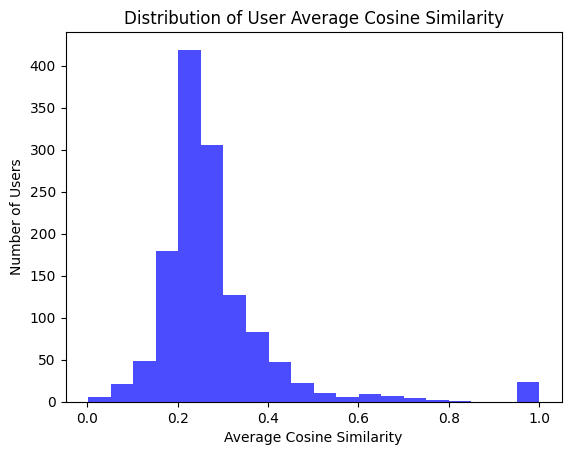

In [41]:
plt.hist(list(user_cosine_means.values()), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of User Average Cosine Similarity')
plt.xlabel('Average Cosine Similarity')
plt.ylabel('Number of Users')
plt.show()

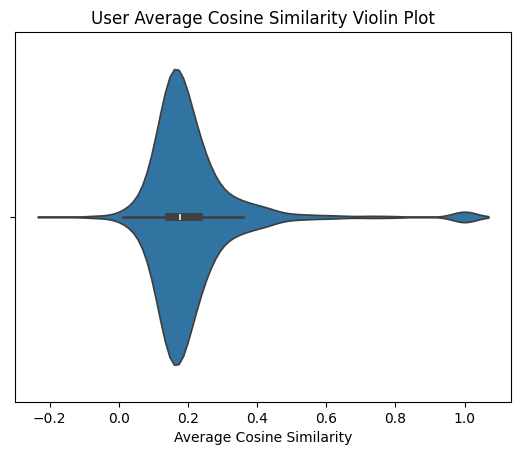

In [37]:
import seaborn as sns

# 바이올린 플롯 그리기
sns.violinplot(data=list(user_cosine_means.values()), orient='h')
plt.title('User Average Cosine Similarity Violin Plot')
plt.xlabel('Average Cosine Similarity')
plt.show()
